# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [35]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dex     1206 non-null   int64 
 1   ac      1206 non-null   int64 
 2   level   1206 non-null   int64 
 3   cha     1206 non-null   int64 
 4   int     1206 non-null   int64 
 5   con     1206 non-null   int64 
 6   str     1206 non-null   int64 
 7   book    1206 non-null   object
 8   wis     1206 non-null   int64 
 9   hp      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [37]:
df.head()

,dex,ac,level,cha,int,con,str,book,wis,hp
0,2,29,10,1,1,5,7,Pathfinder Bestiary,2,215
1,0,28,10,1,-4,5,9,Pathfinder Bestiary,2,220
2,3,25,8,-2,-4,6,7,Pathfinder Bestiary,3,175
3,4,41,17,6,6,5,7,Pathfinder Bestiary,5,315
4,3,16,1,1,-1,1,-5,Pathfinder Bestiary,1,20


###### Level

In [38]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [39]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [40]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


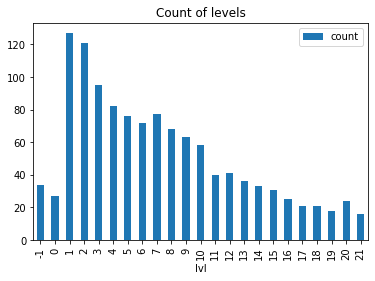

In [41]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [42]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [43]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [44]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [45]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [46]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [47]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [49]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [50]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

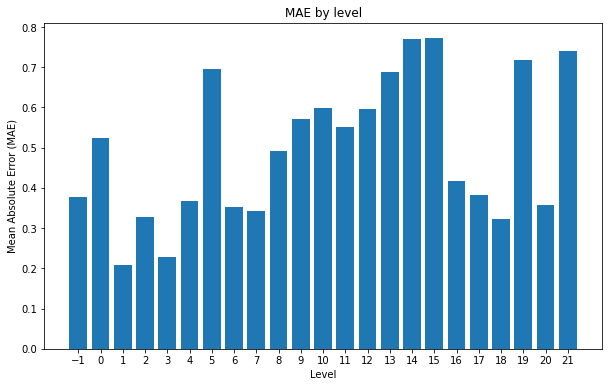

In [51]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [52]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



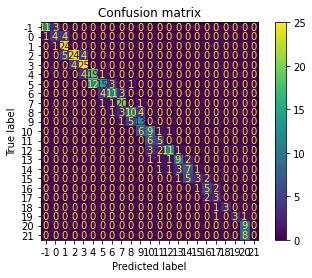

In [53]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [54]:
from training.results import assess_regression_model

In [55]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:29:19,369] A new study created in memory with name: no-name-01d07142-d0ac-4c1c-8570-cb9f47249bfb
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


feature_fraction, val_score: 0.219522:  14%|######4                                      | 1/7 [00:03<00:21,  3.65s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232561 + 0.0496082
[300]	cv_agg's l2: 0.23456 + 0.0509794


feature_fraction, val_score: 0.219522:  29%|############8                                | 2/7 [00:07<00:18,  3.68s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


feature_fraction, val_score: 0.219522:  43%|###################2                         | 3/7 [00:10<00:14,  3.60s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.340919 + 0.0675387
[200]	cv_agg's l2: 0.301922 + 0.0681426
[300]	cv_agg's l2: 0.29213 + 0.0670465


feature_fraction, val_score: 0.219522:  57%|#########################7                   | 4/7 [00:14<00:10,  3.49s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.271271 + 0.0602902
[200]	cv_agg's l2: 0.249718 + 0.0564548
[300]	cv_agg's l2: 0.244871 + 0.0568968


feature_fraction, val_score: 0.219522:  71%|################################1            | 5/7 [00:17<00:06,  3.50s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.238154 + 0.0567627
[200]	cv_agg's l2: 0.233592 + 0.0562554
[300]	cv_agg's l2: 0.235672 + 0.0578072


feature_fraction, val_score: 0.219522:  86%|######################################5      | 6/7 [00:21<00:03,  3.46s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.347847 + 0.0525135
[200]	cv_agg's l2: 0.302351 + 0.0548878
[300]	cv_agg's l2: 0.291286 + 0.0551368


feature_fraction, val_score: 0.219522: 100%|#############################################| 7/7 [00:24<00:00,  3.49s/it]


Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052


num_leaves, val_score: 0.219522:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:   5%|##5                                               | 1/20 [00:03<01:07,  3.57s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  10%|#####                                             | 2/20 [00:07<01:03,  3.51s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  15%|#######5                                          | 3/20 [00:10<01:00,  3.55s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  20%|##########                                        | 4/20 [00:14<00:56,  3.53s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228746 + 0.0380429
[200]	cv_agg's l2: 0.223307 + 0.0388334
[300]	cv_agg's l2: 0.221546 + 0.0365581


num_leaves, val_score: 0.219522:  25%|############5                                     | 5/20 [00:16<00:44,  2.98s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  30%|###############                                   | 6/20 [00:19<00:45,  3.27s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  35%|#################5                                | 7/20 [00:23<00:44,  3.46s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  40%|####################                              | 8/20 [00:27<00:40,  3.40s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  45%|######################5                           | 9/20 [00:29<00:32,  2.96s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  50%|########################5                        | 10/20 [00:31<00:27,  2.76s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  55%|##########################9                      | 11/20 [00:33<00:21,  2.42s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.353362 + 0.0666131
[200]	cv_agg's l2: 0.312844 + 0.064586
[300]	cv_agg's l2: 0.302095 + 0.0648377


num_leaves, val_score: 0.219522:  60%|#############################4                   | 12/20 [00:33<00:14,  1.83s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  65%|###############################8                 | 13/20 [00:35<00:13,  1.90s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  70%|##################################3              | 14/20 [00:38<00:13,  2.22s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  75%|####################################7            | 15/20 [00:41<00:12,  2.42s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  80%|#######################################2         | 16/20 [00:43<00:09,  2.33s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  85%|#########################################6       | 17/20 [00:45<00:06,  2.15s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  90%|############################################1    | 18/20 [00:46<00:03,  1.97s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522:  95%|##############################################5  | 19/20 [00:48<00:01,  1.89s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


num_leaves, val_score: 0.219522: 100%|#################################################| 20/20 [00:50<00:00,  2.51s/it]


Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052


bagging, val_score: 0.219522:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.234475 + 0.0457904
[200]	cv_agg's l2: 0.225786 + 0.0435188
[300]	cv_agg's l2: 0.224294 + 0.0408942


bagging, val_score: 0.219522:  10%|#####3                                               | 1/10 [00:01<00:16,  1.78s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.292906 + 0.0620091
[200]	cv_agg's l2: 0.275321 + 0.0637431
[300]	cv_agg's l2: 0.271932 + 0.0615735


bagging, val_score: 0.219522:  20%|##########6                                          | 2/10 [00:02<00:11,  1.43s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.230381 + 0.0402591
[200]	cv_agg's l2: 0.22241 + 0.0410596
[300]	cv_agg's l2: 0.221302 + 0.0422937


bagging, val_score: 0.219522:  30%|###############9                                     | 3/10 [00:04<00:11,  1.65s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.263958 + 0.0534792
[200]	cv_agg's l2: 0.24993 + 0.0593808
[300]	cv_agg's l2: 0.245454 + 0.0628975


bagging, val_score: 0.219522:  40%|#####################2                               | 4/10 [00:06<00:09,  1.56s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.258679 + 0.0638515
[200]	cv_agg's l2: 0.244468 + 0.0627614
[300]	cv_agg's l2: 0.239085 + 0.0618396


bagging, val_score: 0.219522:  50%|##########################5                          | 5/10 [00:07<00:07,  1.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.300581 + 0.0679774
[200]	cv_agg's l2: 0.280482 + 0.066445
[300]	cv_agg's l2: 0.275029 + 0.0656209


bagging, val_score: 0.219522:  60%|###############################8                     | 6/10 [00:08<00:05,  1.33s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.241908 + 0.0426205
[200]	cv_agg's l2: 0.23312 + 0.0455387
[300]	cv_agg's l2: 0.22891 + 0.0444532


bagging, val_score: 0.219522:  70%|#####################################                | 7/10 [00:10<00:04,  1.39s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.275101 + 0.0656102
[200]	cv_agg's l2: 0.264479 + 0.0722103
[300]	cv_agg's l2: 0.273212 + 0.0784708


bagging, val_score: 0.219522:  80%|##########################################4          | 8/10 [00:11<00:02,  1.36s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.241899 + 0.0517898
[200]	cv_agg's l2: 0.233393 + 0.0472409
[300]	cv_agg's l2: 0.230086 + 0.0466486


bagging, val_score: 0.219522:  90%|###############################################7     | 9/10 [00:12<00:01,  1.37s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.282956 + 0.0580979
[200]	cv_agg's l2: 0.275683 + 0.0663934
[300]	cv_agg's l2: 0.271655 + 0.0672859


bagging, val_score: 0.219522: 100%|####################################################| 10/10 [00:14<00:00,  1.41s/it]


Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052


feature_fraction_stage2, val_score: 0.219522:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.271271 + 0.0602902
[200]	cv_agg's l2: 0.249718 + 0.0564548
[300]	cv_agg's l2: 0.244871 + 0.0568968


feature_fraction_stage2, val_score: 0.219522:  17%|######3                               | 1/6 [00:01<00:07,  1.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


feature_fraction_stage2, val_score: 0.219522:  33%|############6                         | 2/6 [00:03<00:06,  1.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.271271 + 0.0602902
[200]	cv_agg's l2: 0.249718 + 0.0564548
[300]	cv_agg's l2: 0.244871 + 0.0568968


feature_fraction_stage2, val_score: 0.219522:  50%|###################                   | 3/6 [00:04<00:04,  1.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.271271 + 0.0602902
[200]	cv_agg's l2: 0.249718 + 0.0564548
[300]	cv_agg's l2: 0.244871 + 0.0568968


feature_fraction_stage2, val_score: 0.219522:  67%|#########################3            | 4/6 [00:06<00:03,  1.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


feature_fraction_stage2, val_score: 0.219522:  83%|###############################6      | 5/6 [00:07<00:01,  1.57s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


feature_fraction_stage2, val_score: 0.219522: 100%|######################################| 6/6 [00:09<00:00,  1.54s/it]


Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052


regularization_factors, val_score: 0.219522:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.228664 + 0.0356688
[200]	cv_agg's l2: 0.221948 + 0.0389574
[300]	cv_agg's l2: 0.221285 + 0.0400698


regularization_factors, val_score: 0.219522:   5%|#9                                    | 1/20 [00:01<00:33,  1.76s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.291812 + 0.039952
[200]	cv_agg's l2: 0.288328 + 0.0417038


regularization_factors, val_score: 0.219522:  10%|###8                                  | 2/20 [00:02<00:19,  1.07s/it]

[300]	cv_agg's l2: 0.288326 + 0.0417055
Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  15%|#####7                                | 3/20 [00:04<00:23,  1.36s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  20%|#######6                              | 4/20 [00:05<00:23,  1.45s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  25%|#########5                            | 5/20 [00:07<00:23,  1.59s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  30%|###########4                          | 6/20 [00:09<00:22,  1.62s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  35%|#############3                        | 7/20 [00:10<00:20,  1.60s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  40%|###############2                      | 8/20 [00:12<00:19,  1.61s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  45%|#################1                    | 9/20 [00:14<00:18,  1.70s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  50%|##################5                  | 10/20 [00:16<00:17,  1.76s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  55%|####################3                | 11/20 [00:18<00:18,  2.02s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  60%|######################2              | 12/20 [00:20<00:16,  2.04s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  65%|########################             | 13/20 [00:22<00:14,  2.06s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  70%|#########################9           | 14/20 [00:26<00:15,  2.55s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  75%|###########################7         | 15/20 [00:30<00:14,  2.91s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  80%|#############################6       | 16/20 [00:34<00:12,  3.23s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  85%|###############################4     | 17/20 [00:38<00:10,  3.42s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  90%|#################################3   | 18/20 [00:41<00:07,  3.52s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522:  95%|###################################1 | 19/20 [00:45<00:03,  3.55s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.228078 + 0.0374443
[200]	cv_agg's l2: 0.221228 + 0.0393674
[300]	cv_agg's l2: 0.219747 + 0.0403609


regularization_factors, val_score: 0.219522: 100%|#####################################| 20/20 [00:49<00:00,  2.48s/it]


Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052


min_data_in_leaf, val_score: 0.219522:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.340761 + 0.0710209
[200]	cv_agg's l2: 0.326794 + 0.069972
[300]	cv_agg's l2: 0.323144 + 0.0720573


min_data_in_leaf, val_score: 0.219522:  20%|#########                                    | 1/5 [00:01<00:06,  1.68s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.219522 + 0.0403052
[100]	cv_agg's l2: 0.210205 + 0.0351775
[200]	cv_agg's l2: 0.208009 + 0.0378614


min_data_in_leaf, val_score: 0.207452:  40%|##################                           | 2/5 [00:04<00:06,  2.33s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.207452 + 0.0371004
[100]	cv_agg's l2: 0.207442 + 0.0350799


min_data_in_leaf, val_score: 0.206614:  60%|###########################                  | 3/5 [00:06<00:04,  2.27s/it]

[200]	cv_agg's l2: 0.207294 + 0.0340962
Early stopping, best iteration is:
[115]	cv_agg's l2: 0.206614 + 0.0344551
[100]	cv_agg's l2: 0.260176 + 0.0668304


min_data_in_leaf, val_score: 0.206614:  80%|####################################         | 4/5 [00:08<00:01,  1.96s/it]

[200]	cv_agg's l2: 0.246726 + 0.0660632
Early stopping, best iteration is:
[115]	cv_agg's l2: 0.206614 + 0.0344551
[100]	cv_agg's l2: 0.814899 + 0.163146


min_data_in_leaf, val_score: 0.206614: 100%|#############################################| 5/5 [00:08<00:00,  1.74s/it]

[200]	cv_agg's l2: 0.800739 + 0.170661
Early stopping, best iteration is:
[115]	cv_agg's l2: 0.206614 + 0.0344551


In [56]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.20661353082644146
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 7.301416517103133e-07
    lambda_l2: 8.346246752000561e-07
    num_leaves: 31
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [57]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [58]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.67
MSE test: 0.45
MAE test: 0.47



In [59]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

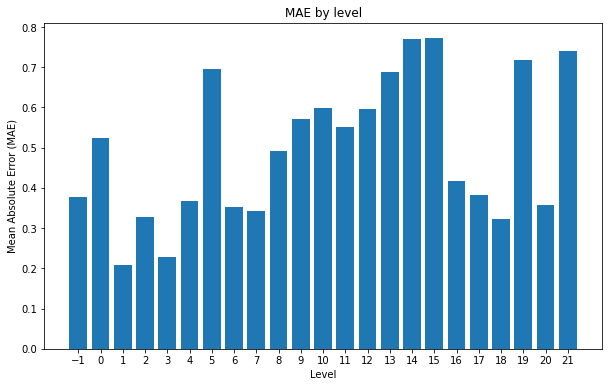

In [60]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [61]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.53
RMSE: 0.73

Round type: 0.33
MSE: 0.48
RMSE: 0.69

Round type: 0.45
MSE: 0.51
RMSE: 0.72



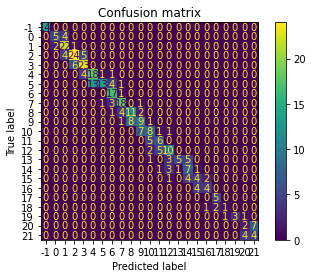

In [62]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [63]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.340495	valid_0's l2: 0.243018


In [64]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [66]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

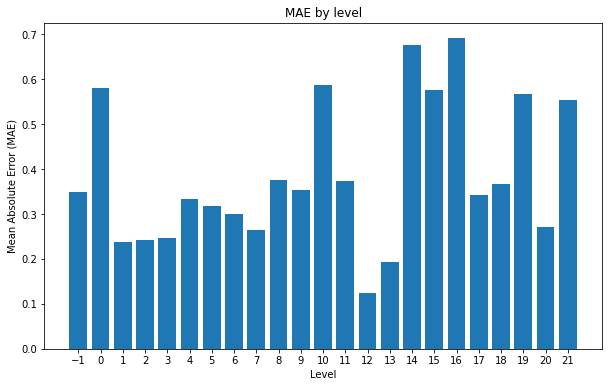

In [67]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [68]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



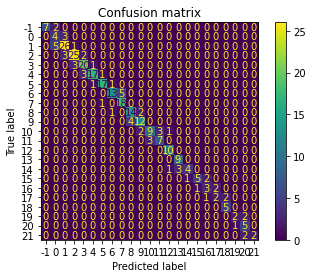

In [69]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [70]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:32:13,065] A new study created in memory with name: no-name-8bb623eb-2570-4295-b64b-7d0d816cca12
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.256328 + 0.0777765
[200]	cv_agg's l2: 0.259774 + 0.07799


feature_fraction, val_score: 0.254560:  14%|######4                                      | 1/7 [00:02<00:14,  2.40s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.25456 + 0.0787984
[100]	cv_agg's l2: 0.249836 + 0.0499123
[200]	cv_agg's l2: 0.251068 + 0.0478294


feature_fraction, val_score: 0.248963:  29%|############8                                | 2/7 [00:04<00:11,  2.32s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.248963 + 0.0478897
[100]	cv_agg's l2: 0.357317 + 0.0561993
[200]	cv_agg's l2: 0.313448 + 0.0582977


feature_fraction, val_score: 0.248963:  43%|###################2                         | 3/7 [00:06<00:09,  2.26s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.248963 + 0.0478897
[100]	cv_agg's l2: 0.293528 + 0.0529884
[200]	cv_agg's l2: 0.282965 + 0.0538002


feature_fraction, val_score: 0.248963:  57%|#########################7                   | 4/7 [00:08<00:06,  2.18s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.248963 + 0.0478897
[100]	cv_agg's l2: 0.249836 + 0.0499123
[200]	cv_agg's l2: 0.251068 + 0.0478294


feature_fraction, val_score: 0.248963:  71%|################################1            | 5/7 [00:11<00:04,  2.22s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.248963 + 0.0478897
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


feature_fraction, val_score: 0.244107:  86%|######################################5      | 6/7 [00:13<00:02,  2.28s/it]

Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744
[100]	cv_agg's l2: 0.350491 + 0.0542453
[200]	cv_agg's l2: 0.325701 + 0.0532011


feature_fraction, val_score: 0.244107: 100%|#############################################| 7/7 [00:15<00:00,  2.25s/it]


Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744


num_leaves, val_score: 0.244107:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.244107:   5%|##5                                               | 1/20 [00:02<00:46,  2.45s/it]

Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.244107:  10%|#####                                             | 2/20 [00:04<00:42,  2.37s/it]

Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.244107:  15%|#######5                                          | 3/20 [00:07<00:39,  2.34s/it]

Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.244107:  20%|##########                                        | 4/20 [00:09<00:36,  2.28s/it]

Early stopping, best iteration is:
[126]	cv_agg's l2: 0.244107 + 0.0688744
[100]	cv_agg's l2: 0.245927 + 0.0704663
[200]	cv_agg's l2: 0.242369 + 0.0649528
[300]	cv_agg's l2: 0.240747 + 0.0617901


num_leaves, val_score: 0.240290:  25%|############5                                     | 5/20 [00:11<00:31,  2.13s/it]

[400]	cv_agg's l2: 0.241585 + 0.0608002
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.24029 + 0.061753
[100]	cv_agg's l2: 0.242999 + 0.0707142
[200]	cv_agg's l2: 0.240244 + 0.0653942


num_leaves, val_score: 0.239399:  30%|###############                                   | 6/20 [00:12<00:26,  1.88s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244504 + 0.0756951
[200]	cv_agg's l2: 0.245294 + 0.0696799


num_leaves, val_score: 0.239399:  35%|#################5                                | 7/20 [00:13<00:22,  1.72s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244647 + 0.0687337
[200]	cv_agg's l2: 0.244892 + 0.0661827


num_leaves, val_score: 0.239399:  40%|####################                              | 8/20 [00:16<00:25,  2.10s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.248377 + 0.0677582
[200]	cv_agg's l2: 0.242384 + 0.0645847


num_leaves, val_score: 0.239399:  45%|######################5                           | 9/20 [00:17<00:19,  1.81s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  50%|########################5                        | 10/20 [00:21<00:21,  2.20s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  55%|##########################9                      | 11/20 [00:24<00:21,  2.44s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  60%|#############################4                   | 12/20 [00:26<00:20,  2.55s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  65%|###############################8                 | 13/20 [00:29<00:18,  2.64s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  70%|##################################3              | 14/20 [00:32<00:16,  2.80s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.277392 + 0.07823
[200]	cv_agg's l2: 0.262399 + 0.0668978


num_leaves, val_score: 0.239399:  75%|####################################7            | 15/20 [00:33<00:11,  2.21s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  80%|#######################################2         | 16/20 [00:37<00:10,  2.62s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.251358 + 0.0766206
[200]	cv_agg's l2: 0.245262 + 0.073664


num_leaves, val_score: 0.239399:  85%|#########################################6       | 17/20 [00:38<00:06,  2.23s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  90%|############################################1    | 18/20 [00:41<00:05,  2.55s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.244163 + 0.0691625
[200]	cv_agg's l2: 0.245107 + 0.0660758


num_leaves, val_score: 0.239399:  95%|##############################################5  | 19/20 [00:45<00:02,  2.99s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.329299 + 0.0905132


num_leaves, val_score: 0.239399:  95%|##############################################5  | 19/20 [00:46<00:02,  2.99s/it]

[200]	cv_agg's l2: 0.290826 + 0.081431
Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105


bagging, val_score: 0.239399:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.26429 + 0.0563806
[200]	cv_agg's l2: 0.260104 + 0.057965


bagging, val_score: 0.239399:  10%|#####3                                               | 1/10 [00:02<00:18,  2.07s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.239399 + 0.0653105
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737
[300]	cv_agg's l2: 0.240721 + 0.0525721


bagging, val_score: 0.237461:  20%|##########6                                          | 2/10 [00:04<00:18,  2.25s/it]

Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.245103 + 0.0655766
[200]	cv_agg's l2: 0.242244 + 0.0609634


bagging, val_score: 0.237461:  30%|###############9                                     | 3/10 [00:06<00:15,  2.24s/it]

[300]	cv_agg's l2: 0.244135 + 0.0587913
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.246179 + 0.0681365
[200]	cv_agg's l2: 0.242232 + 0.0662252


bagging, val_score: 0.237461:  40%|#####################2                               | 4/10 [00:08<00:13,  2.21s/it]

[300]	cv_agg's l2: 0.243138 + 0.0634587
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.247091 + 0.0730372
[200]	cv_agg's l2: 0.245715 + 0.0686932


bagging, val_score: 0.237461:  50%|##########################5                          | 5/10 [00:11<00:11,  2.31s/it]

[300]	cv_agg's l2: 0.250033 + 0.0687656
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.248211 + 0.0609519
[200]	cv_agg's l2: 0.247001 + 0.0532595


bagging, val_score: 0.237461:  50%|##########################5                          | 5/10 [00:13<00:11,  2.31s/it]

[300]	cv_agg's l2: 0.248428 + 0.0526197
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


bagging, val_score: 0.237461:  60%|###############################8                     | 6/10 [00:13<00:09,  2.35s/it]

[100]	cv_agg's l2: 0.320528 + 0.0672981
[200]	cv_agg's l2: 0.31498 + 0.0614825


bagging, val_score: 0.237461:  70%|#####################################                | 7/10 [00:15<00:06,  2.29s/it]

[300]	cv_agg's l2: 0.308116 + 0.0601347
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.245177 + 0.0600491
[200]	cv_agg's l2: 0.240409 + 0.0568421


bagging, val_score: 0.237461:  70%|#####################################                | 7/10 [00:18<00:06,  2.29s/it]

[300]	cv_agg's l2: 0.241834 + 0.0540906
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


bagging, val_score: 0.237461:  80%|##########################################4          | 8/10 [00:18<00:04,  2.28s/it]

[100]	cv_agg's l2: 0.247373 + 0.0541917
[200]	cv_agg's l2: 0.242362 + 0.0487727


bagging, val_score: 0.237461:  90%|###############################################7     | 9/10 [00:20<00:02,  2.29s/it]

[300]	cv_agg's l2: 0.249369 + 0.0467615
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.250749 + 0.0641834
[200]	cv_agg's l2: 0.247218 + 0.0626602


bagging, val_score: 0.237461: 100%|####################################################| 10/10 [00:22<00:00,  2.28s/it]


[300]	cv_agg's l2: 0.249643 + 0.0581541
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


feature_fraction_stage2, val_score: 0.237461:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


feature_fraction_stage2, val_score: 0.237461:   0%|                                              | 0/6 [00:02<?, ?it/s]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


feature_fraction_stage2, val_score: 0.237461:  17%|######3                               | 1/6 [00:02<00:11,  2.21s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


feature_fraction_stage2, val_score: 0.237461:  33%|############6                         | 2/6 [00:04<00:08,  2.23s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.24795 + 0.0645948
[200]	cv_agg's l2: 0.248967 + 0.063808


feature_fraction_stage2, val_score: 0.237461:  50%|###################                   | 3/6 [00:06<00:06,  2.28s/it]

[300]	cv_agg's l2: 0.251411 + 0.0649579
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


feature_fraction_stage2, val_score: 0.237461:  50%|###################                   | 3/6 [00:09<00:06,  2.28s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


feature_fraction_stage2, val_score: 0.237461:  67%|#########################3            | 4/6 [00:09<00:04,  2.27s/it]

[100]	cv_agg's l2: 0.24795 + 0.0645948
[200]	cv_agg's l2: 0.248967 + 0.063808


feature_fraction_stage2, val_score: 0.237461:  67%|#########################3            | 4/6 [00:11<00:04,  2.27s/it]

[300]	cv_agg's l2: 0.251411 + 0.0649579
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


feature_fraction_stage2, val_score: 0.237461:  83%|###############################6      | 5/6 [00:11<00:02,  2.32s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


feature_fraction_stage2, val_score: 0.237461: 100%|######################################| 6/6 [00:14<00:00,  2.36s/it]


[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.248442 + 0.0714199
[200]	cv_agg's l2: 0.246636 + 0.0668226


regularization_factors, val_score: 0.237461:   5%|#9                                    | 1/20 [00:02<00:48,  2.56s/it]

[300]	cv_agg's l2: 0.247985 + 0.0654481
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


[I 2023-10-28 22:33:54,908] Trial 43 finished with value: 0.2470251620188732 and parameters: {'lambda_l1': 0.3566590981108635, 'lambda_l2': 0.001697572848613005}. Best is trial 43 with value: 0.2470251620188732.
regularization_factors, val_score: 0.237461:   5%|#9                                    | 1/20 [00:02<00:48,  2.56s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737
[300]	cv_agg's l2: 0.240721 + 0.0525721


regularization_factors, val_score: 0.237461:  10%|###8                                  | 2/20 [00:05<00:53,  2.95s/it]

Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737
[300]	cv_agg's l2: 0.240721 + 0.0525721


regularization_factors, val_score: 0.237461:  15%|#####7                                | 3/20 [00:09<00:57,  3.40s/it]

Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  20%|#######6                              | 4/20 [00:12<00:48,  3.04s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  20%|#######6                              | 4/20 [00:14<00:48,  3.04s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  25%|#########5                            | 5/20 [00:14<00:41,  2.79s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  30%|###########4                          | 6/20 [00:16<00:36,  2.61s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  35%|#############3                        | 7/20 [00:19<00:32,  2.49s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  40%|###############2                      | 8/20 [00:21<00:28,  2.40s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  40%|###############2                      | 8/20 [00:23<00:28,  2.40s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  45%|#################1                    | 9/20 [00:23<00:25,  2.32s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  50%|##################5                  | 10/20 [00:25<00:22,  2.28s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  55%|####################3                | 11/20 [00:27<00:20,  2.28s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  60%|######################2              | 12/20 [00:30<00:17,  2.25s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  65%|########################             | 13/20 [00:32<00:15,  2.25s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  65%|########################             | 13/20 [00:34<00:15,  2.25s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  70%|#########################9           | 14/20 [00:34<00:13,  2.31s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  70%|#########################9           | 14/20 [00:37<00:13,  2.31s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  75%|###########################7         | 15/20 [00:37<00:12,  2.51s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  75%|###########################7         | 15/20 [00:40<00:12,  2.51s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  80%|#############################6       | 16/20 [00:40<00:09,  2.47s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737
[300]	cv_agg's l2: 0.240721 + 0.0525721


regularization_factors, val_score: 0.237461:  85%|###############################4     | 17/20 [00:42<00:07,  2.51s/it]

Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  85%|###############################4     | 17/20 [00:45<00:07,  2.51s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


regularization_factors, val_score: 0.237461:  90%|#################################3   | 18/20 [00:45<00:05,  2.52s/it]

[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461:  95%|###################################1 | 19/20 [00:47<00:02,  2.47s/it]

[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843
[100]	cv_agg's l2: 0.241445 + 0.0597723
[200]	cv_agg's l2: 0.238347 + 0.0547737


regularization_factors, val_score: 0.237461: 100%|#####################################| 20/20 [00:49<00:00,  2.50s/it]


[300]	cv_agg's l2: 0.240721 + 0.0525721
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.237461 + 0.054843


min_data_in_leaf, val_score: 0.237461:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.22875 + 0.0661268


min_data_in_leaf, val_score: 0.228570:  20%|#########                                    | 1/5 [00:01<00:05,  1.30s/it]

Early stopping, best iteration is:
[88]	cv_agg's l2: 0.22857 + 0.0651721
[100]	cv_agg's l2: 0.26763 + 0.0758962


min_data_in_leaf, val_score: 0.228570:  40%|##################                           | 2/5 [00:02<00:03,  1.30s/it]

Early stopping, best iteration is:
[88]	cv_agg's l2: 0.22857 + 0.0651721
[100]	cv_agg's l2: 0.225683 + 0.0612087
[200]	cv_agg's l2: 0.22359 + 0.0610094


min_data_in_leaf, val_score: 0.223016:  60%|###########################                  | 3/5 [00:04<00:03,  1.67s/it]

Early stopping, best iteration is:
[189]	cv_agg's l2: 0.223016 + 0.0611176
[100]	cv_agg's l2: 0.844568 + 0.0630381
[200]	cv_agg's l2: 0.812835 + 0.0719264


min_data_in_leaf, val_score: 0.223016:  80%|####################################         | 4/5 [00:06<00:01,  1.53s/it]

Early stopping, best iteration is:
[189]	cv_agg's l2: 0.223016 + 0.0611176
[100]	cv_agg's l2: 0.338361 + 0.0879649
[200]	cv_agg's l2: 0.335374 + 0.0807502


min_data_in_leaf, val_score: 0.223016: 100%|#############################################| 5/5 [00:08<00:00,  1.62s/it]

Early stopping, best iteration is:
[189]	cv_agg's l2: 0.223016 + 0.0611176


In [71]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.2230155485539264
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.6951111599521486e-06
    lambda_l2: 1.4704338452328837e-06
    num_leaves: 11
    feature_fraction: 0.8999999999999999
    bagging_fraction: 0.9602651689150259
    bagging_freq: 1
    min_child_samples: 5


In [72]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [73]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.50
MSE test: 0.25
MAE test: 0.32



In [74]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

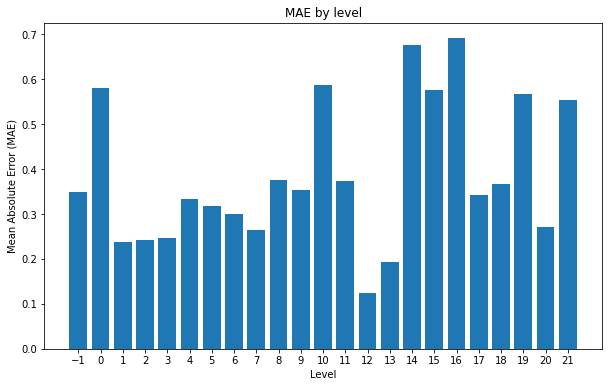

In [75]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [76]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.11
RMSE: 0.33

Round type: round
MSE: 0.11
RMSE: 0.33

Round type: 0.33
MSE: 0.14
RMSE: 0.37

Round type: 0.45
MSE: 0.12
RMSE: 0.35



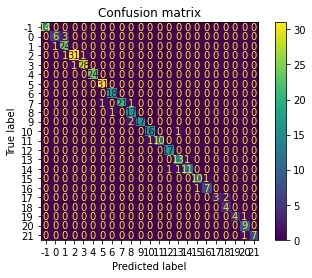

In [77]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [78]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.447566,0.669004,0.467604
1,chronological,Optuna,8,0.449565,0.670496,0.471456
3,random,normal,8,0.243018,0.492968,0.340495
4,random,Optuna,8,0.248872,0.498871,0.317802


In [79]:
from training.results import plot_summary

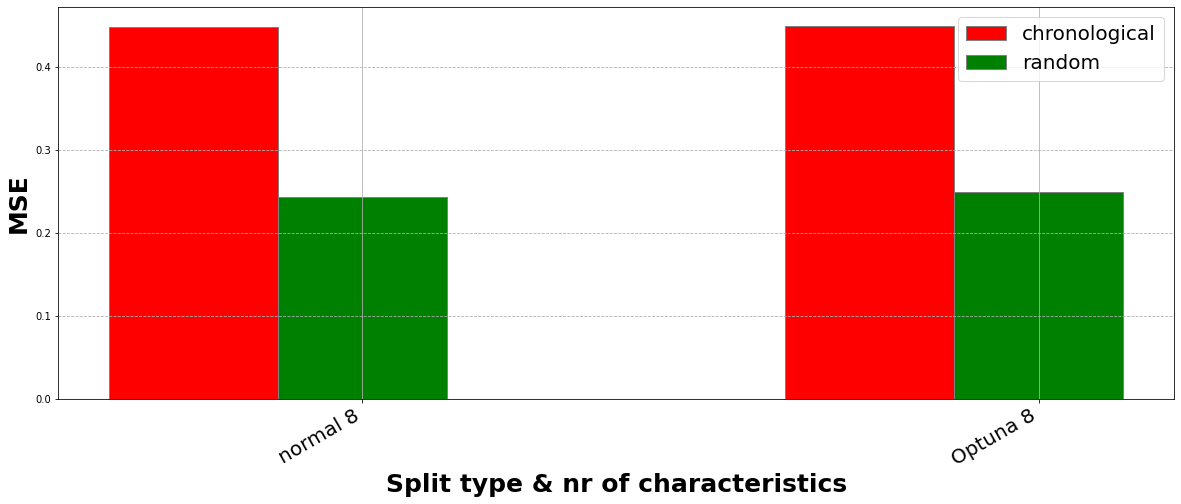

In [80]:
plot_summary(results, "MSE")

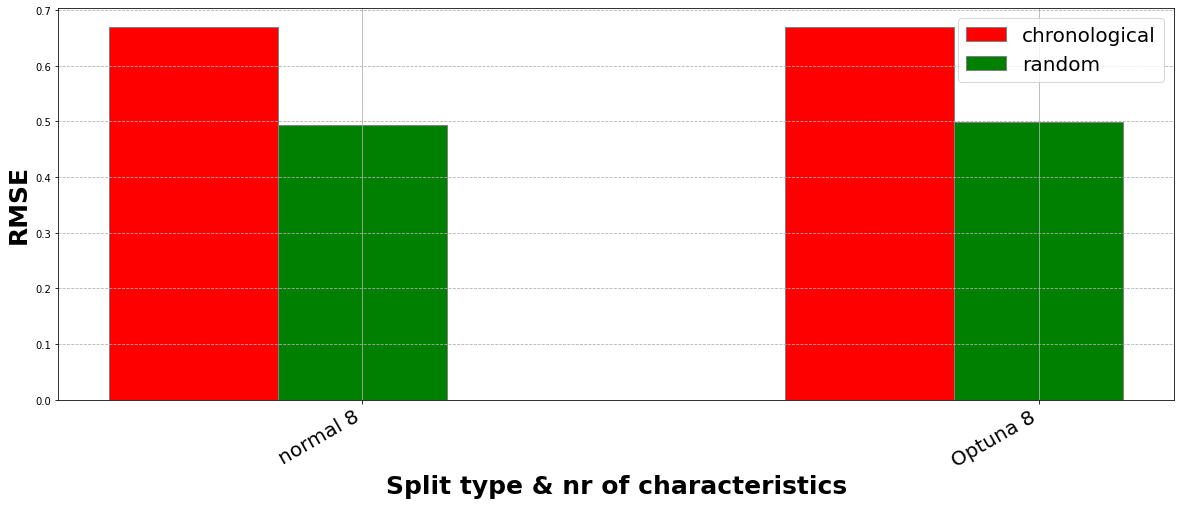

In [81]:
plot_summary(results, "RMSE")

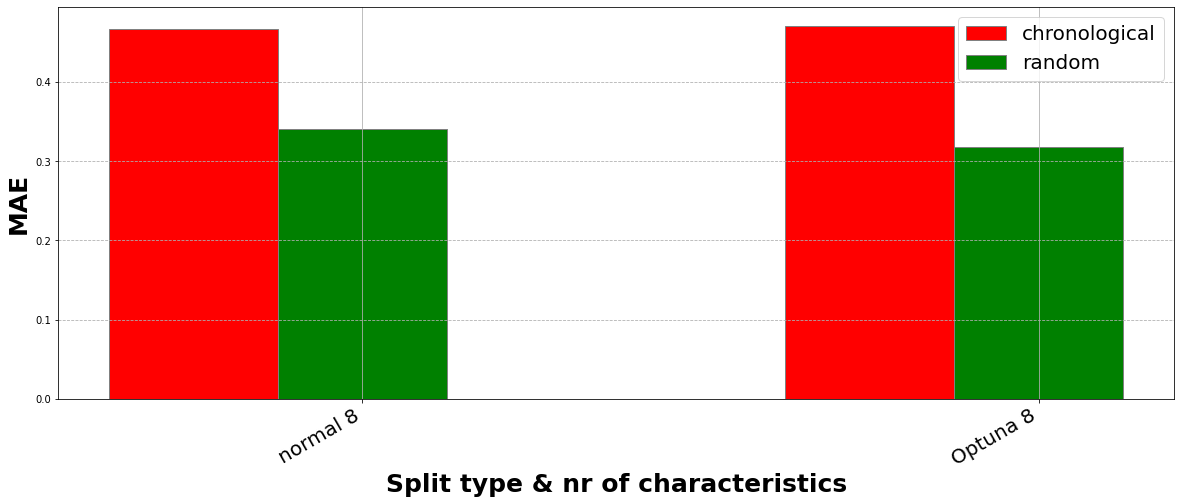

In [82]:
plot_summary(results, "MAE")

In [83]:
results.to_json("./lightgbm_basic_results.json")